In [1]:
import pandas as pd

# Load the data from the uploaded file
file_path = 'https://raw.githubusercontent.com/jrobledob/R2M_Colombia_banana_and_plantain/main/Data/DATA_MAP_Network_Human_Movement_2023_12_08.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

,Unnamed: 0,Amazonas,Antioquia,Arauca,Atlántico,Bolívar,Boyacá,Caldas,Caquetá,Casanare,...,Costa Rica,Honduras,Brazil,Peru.1,Guatemala,Panama,Ecuador,Bolivia,Chile,USA
0,Amazonas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Antioquia,0,"P, S, M","P, S",0,0,0,P,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Arauca,0,M,"M, P",0,0,P,0,0,P,...,0,0,0,0,0,0,0,0,0,0
3,Atlántico,0,S,P,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bolívar,0,0,0,0,0,0,P,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
# Transform the data from wide format to long format
long_format_data = data.melt(id_vars=['Unnamed: 0'], var_name='To', value_name='Value')
long_format_data.rename(columns={'Unnamed: 0': 'From'}, inplace=True)

# Filter out rows where Value is 0, as they do not represent any interaction
long_format_data = long_format_data[long_format_data['Value'] != 0]

# Display the first few rows of the transformed data
long_format_data.head()

,From,To,Value
54,Amazonas,Antioquia,0
55,Antioquia,Antioquia,"P, S, M"
56,Arauca,Antioquia,M
57,Atlántico,Antioquia,S
58,Bolívar,Antioquia,0


In [3]:
# Remove rows where the 'Value' column is 0
filtered_data = long_format_data[long_format_data['Value'] != '0']

# Display the first few rows of the filtered data
filtered_data.head()
#filtered_data.to_csv("C:/Users/jrobl/data.csv")

,From,To,Value
55,Antioquia,Antioquia,"P, S, M"
56,Arauca,Antioquia,M
57,Atlántico,Antioquia,S
60,Caldas,Antioquia,P
67,Cundinamarca,Antioquia,P


In [4]:
# Splitting the 'Value' column by commas and expanding into separate rows
# This will duplicate the 'From' and 'To' columns for each value in 'Value' column
expanded_data = filtered_data.assign(Value=filtered_data['Value'].str.split(', ')).explode('Value')

# Display the first few rows of the expanded data
expanded_data.head()
#expanded_data.to_csv("C:/Users/jrobl/data.csv")

,From,To,Value
55,Antioquia,Antioquia,P
55,Antioquia,Antioquia,S
55,Antioquia,Antioquia,M
56,Arauca,Antioquia,M
57,Atlántico,Antioquia,S


     Node Label    Color
0     Antioquia    green
1        Arauca   orange
2     Atlántico   orange
3        Caldas     grey
4  Cundinamarca  magenta


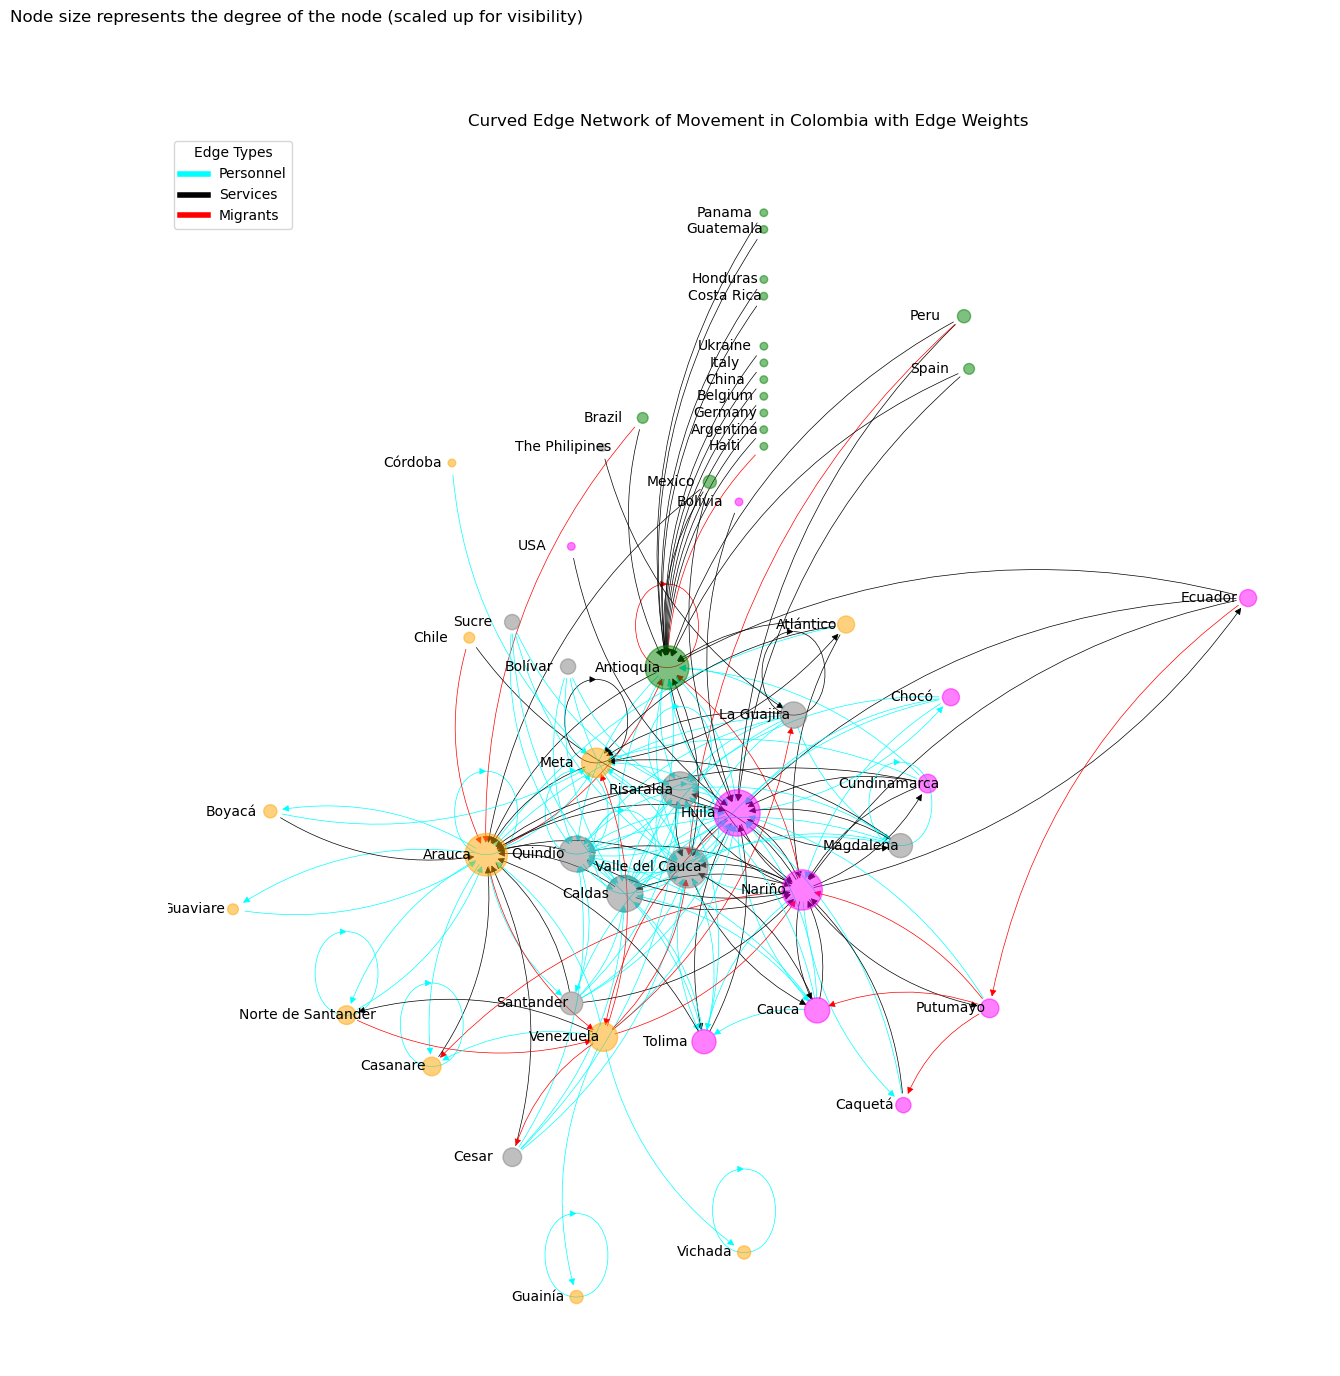

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
from matplotlib.lines import Line2D

expanded_data['Value'] = expanded_data['Value'].replace({
    'P': 'Personnel',
    'S': 'Services',
    'M': 'Migrants'
})


# Define edge colors with updated labels
edge_color_map = {
    'Personnel': "cyan",
    'Services': "black",
    'Migrants': "red"
}


# Create the network using expanded_data
binary_network = nx.DiGraph()

# Add nodes and edges to the graph with the correct attributes and weights
for index, row in expanded_data.iterrows():
    # Calculate the weight for each edge
    edge_weight = 10
    # Check if edge_weight is NaN and assign a small value if true
    if np.isnan(edge_weight):
        edge_weight = 10  # Assign a default small value to NaN weights
    binary_network.add_edge(row['From'], row['To'], value=row['Value'], weight=edge_weight)

# Calculate the layout after all nodes and edges have been added
pos_kamada_kawai = nx.kamada_kawai_layout(binary_network)
# List of countries to adjust
countries = ['Haiti', 'Argentina', 'Germany', 'Belgium', 'China', 'Italy', 
             'Ukraine', 'Spain', 'Mexico', 'Costa Rica', 'Honduras', 'Brazil', 
             'Peru', 'Guatemala', 'Panama', 'Ecuador']

# Initial offset values
right_offset = 0.4
up_offset = 0.03

# Adjust positions for each country
for country in countries:
    if country in pos_kamada_kawai:
        pos_kamada_kawai[country] = (pos_kamada_kawai[country][0] + right_offset, 
                                     pos_kamada_kawai[country][1] + up_offset)

        # Increase the offset for the next country
        up_offset += 0.03
    
    
if 'Bolívar' in pos_kamada_kawai:
    pos_kamada_kawai['Bolívar'] = (pos_kamada_kawai['Bolívar'][0] + 0.1, pos_kamada_kawai['Bolívar'][1] - 0.08)
if 'Vichada' in pos_kamada_kawai:
    pos_kamada_kawai['Vichada'] = (pos_kamada_kawai['Vichada'][0] + 0.3, pos_kamada_kawai['Vichada'][1] + 0.08)
if 'Spain' in pos_kamada_kawai:
    pos_kamada_kawai['Spain'] = (pos_kamada_kawai['Spain'][0] + 0.3, pos_kamada_kawai['Spain'][1] + 0.08)
if 'Peru' in pos_kamada_kawai:
    pos_kamada_kawai['Peru'] = (pos_kamada_kawai['Peru'][0] + 0.3, pos_kamada_kawai['Peru'][1] + 0.08)
if 'Bolivia' in pos_kamada_kawai:
    pos_kamada_kawai['Bolivia'] = (pos_kamada_kawai['Bolivia'][0] + 0.3, pos_kamada_kawai['Bolivia'][1] + 0.08)


    
    
    

# Use NetworkX's built-in algorithms for community detection
communities = nx_comm.greedy_modularity_communities(binary_network)

# Create a mapping of node to community index
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# Draw the network with curved edges
fig, ax = plt.subplots(figsize=(15, 16))

# Calculate node sizes based on degrees and make them 10 times bigger
node_degrees = dict(binary_network.degree())
node_sizes = [v * 100 for v in node_degrees.values()]  # Scale node size by degree





# Community colors as specified
community_colors_specified = ['green', 'orange', 'grey', 'magenta']
# Assigning colors to nodes based on their community
community_colors = [community_colors_specified[community_map[node] % len(community_colors_specified)] for node in binary_network.nodes()]


# Optionally, reduce the node sizes slightly if they are too large
scaled_node_sizes = [size * 0.3 for size in node_sizes]  # Scale down if needed
nx.draw_networkx_nodes(binary_network, pos=pos_kamada_kawai, node_size=scaled_node_sizes, node_color=community_colors, ax=ax, alpha=0.50)

# Draw curved edges with weights
for u, v in binary_network.edges():
    # Adjust the edge width based on the weight
    edge_width = binary_network[u][v]['weight'] * 0.05  # Scale the weight for visualization purposes
    # Adjust the rad value for better visibility of arrows
    nx.draw_networkx_edges(binary_network, pos=pos_kamada_kawai, edgelist=[(u, v)], width=edge_width, edge_color=edge_color_map.get(binary_network[u][v]['value'], 'black'), ax=ax, arrows=True, connectionstyle='arc3,rad=0.2')  # Increase rad for more curvature

# Adjust the position of the labels
label_pos = {node: (pos[0] - 0.07, pos[1]) for node, pos in pos_kamada_kawai.items()}
nx.draw_networkx_labels(binary_network, pos=label_pos, ax=ax, font_size=10)

# Assuming community_map is a dictionary mapping node labels to community indices
# and community_colors_specified is a list with colors for each community

# First, create a dictionary that maps nodes to their respective colors
node_color_map = {node: community_colors_specified[community_map[node] % len(community_colors_specified)] for node in binary_network.nodes()}

# Now, convert this dictionary to a pandas DataFrame
node_colors_df = pd.DataFrame(list(node_color_map.items()), columns=['Node Label', 'Color'])

# Display the first few rows to check
print(node_colors_df.head())  # Corrected line

# Create custom legend for edge colors
legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for label, color in edge_color_map.items()]
ax.legend(handles=legend_elements, title="Edge Types", loc='upper left')

# Annotate for node sizes and edge weights
plt.figtext(0.02, 0.95, "Node size represents the degree of the node (scaled up for visibility)", wrap=True, horizontalalignment='left', fontsize=12)
plt.title("Curved Edge Network of Movement in Colombia with Edge Weights")
plt.axis('off')
plt.show()

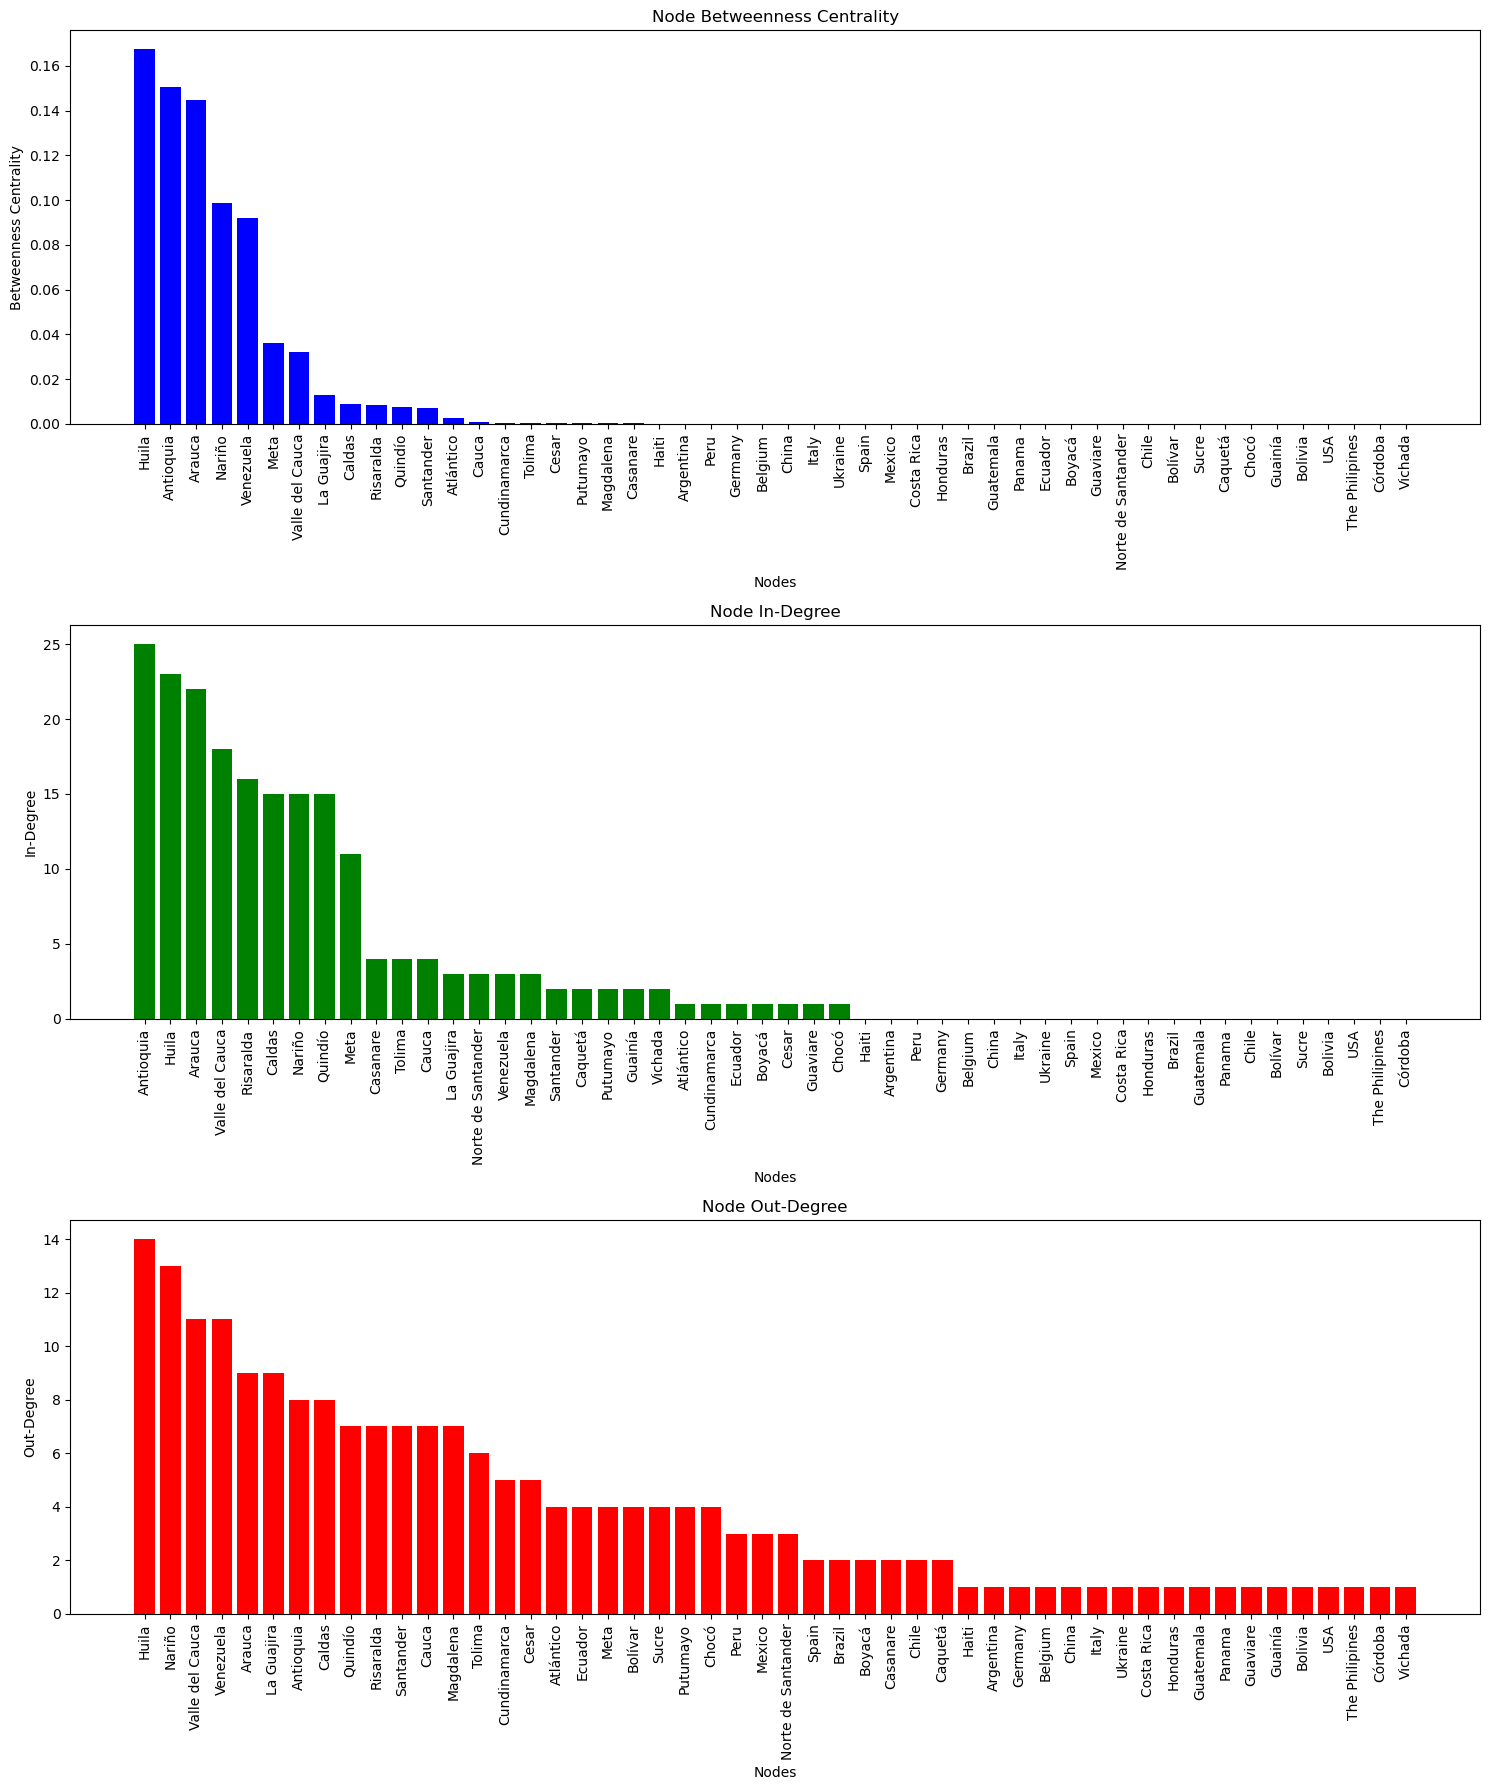

In [6]:
# Calculate betweenness centrality for nodes
node_betweenness = nx.betweenness_centrality(binary_network)

# Calculate in-degree and out-degree
in_degrees = dict(binary_network.in_degree())
out_degrees = dict(binary_network.out_degree())

# Sort the nodes by betweenness centrality in descending order
sorted_betweenness = sorted(node_betweenness.items(), key=lambda item: item[1], reverse=True)
nodes_betweenness, betweenness_values = zip(*sorted_betweenness)

# Sort the nodes by in-degree in descending order
sorted_in_degrees = sorted(in_degrees.items(), key=lambda item: item[1], reverse=True)
nodes_in_degree, in_degree_values = zip(*sorted_in_degrees)

# Sort the nodes by out-degree in descending order
sorted_out_degrees = sorted(out_degrees.items(), key=lambda item: item[1], reverse=True)
nodes_out_degree, out_degree_values = zip(*sorted_out_degrees)

# Create bar plots
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Betweenness Centrality Bar Plot
axes[0].bar(nodes_betweenness, betweenness_values, color='blue')
axes[0].set_xlabel('Nodes')
axes[0].set_ylabel('Betweenness Centrality')
axes[0].set_title('Node Betweenness Centrality')
axes[0].tick_params(axis='x', rotation=90)

# In-Degree Bar Plot
axes[1].bar(nodes_in_degree, in_degree_values, color='green')
axes[1].set_xlabel('Nodes')
axes[1].set_ylabel('In-Degree')
axes[1].set_title('Node In-Degree')
axes[1].tick_params(axis='x', rotation=90)

# Out-Degree Bar Plot
axes[2].bar(nodes_out_degree, out_degree_values, color='red')
axes[2].set_xlabel('Nodes')
axes[2].set_ylabel('Out-Degree')
axes[2].set_title('Node Out-Degree')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [7]:
import pandas as pd

# Assuming community_map is a dictionary mapping node labels to community indices
# and community_colors_specified is a list with colors for each community

# First, create a dictionary that maps nodes to their respective colors
node_color_map = {node: community_colors_specified[community_map[node] % len(community_colors_specified)] for node in binary_network.nodes()}

# Now, convert this dictionary to a pandas DataFrame
node_colors_df = pd.DataFrame(list(node_color_map.items()), columns=['Node Label', 'Color'])

# Display the first few rows to check
print(node_colors_df)
node_colors_df['Color'].unique()

            Node Label    Color
0            Antioquia    green
1               Arauca   orange
2            Atlántico   orange
3               Caldas     grey
4         Cundinamarca  magenta
5                Huila  magenta
6           La Guajira     grey
7               Nariño  magenta
8      Valle del Cauca     grey
9                Haiti    green
10           Argentina    green
11                Peru    green
12             Germany    green
13             Belgium    green
14               China    green
15               Italy    green
16             Ukraine    green
17               Spain    green
18              Mexico    green
19          Costa Rica    green
20            Honduras    green
21              Brazil    green
22           Guatemala    green
23              Panama    green
24             Ecuador  magenta
25              Boyacá   orange
26            Casanare   orange
27               Cesar     grey
28            Guaviare   orange
29                Meta   orange
30  Nort

array(['green', 'orange', 'grey', 'magenta'], dtype=object)

In [8]:
# Filtered and corrected dataset
data = {
    'Node Label': [
        'ANTIOQUIA', 'ARAUCA', 'ATLÁNTICO', 'CALDAS', 'CUNDINAMARCA', 'HUILA', 'LA GUAJIRA', 'NARIÑO', 'VALLE DEL CAUCA',
    'BOYACÁ', 'CASANARE', 'CESAR', 'GUAVIARE', 'META', 'NORTE DE SANTANDER', 'QUINDIO', 'RISARALDA', 'SANTANDER', 'TOLIMA',
    'BOLÍVAR', 'CAUCA', 'MAGDALENA', 'SUCRE', 'CAQUETÁ', 'PUTUMAYO', 'CHOCÓ', 'GUAINÍA', 'CÓRDOBA', 'VICHADA'
    ],
    'Color': [
       'green', 'orange', 'orange', 'grey', 'magenta', 'magenta', 'grey', 'magenta', 'grey', 
    'orange', 'orange', 'grey', 'orange', 'orange', 'orange', 'grey', 'grey', 'grey', 
    'magenta', 'grey', 'magenta', 'grey', 'grey', 'magenta', 'magenta', 'magenta', 'orange', 
    'orange', 'orange'
    ]
}

# Note: Removed non-Colombian departments and adjusted names to match the given list.
df_filtered =pd.DataFrame(data)

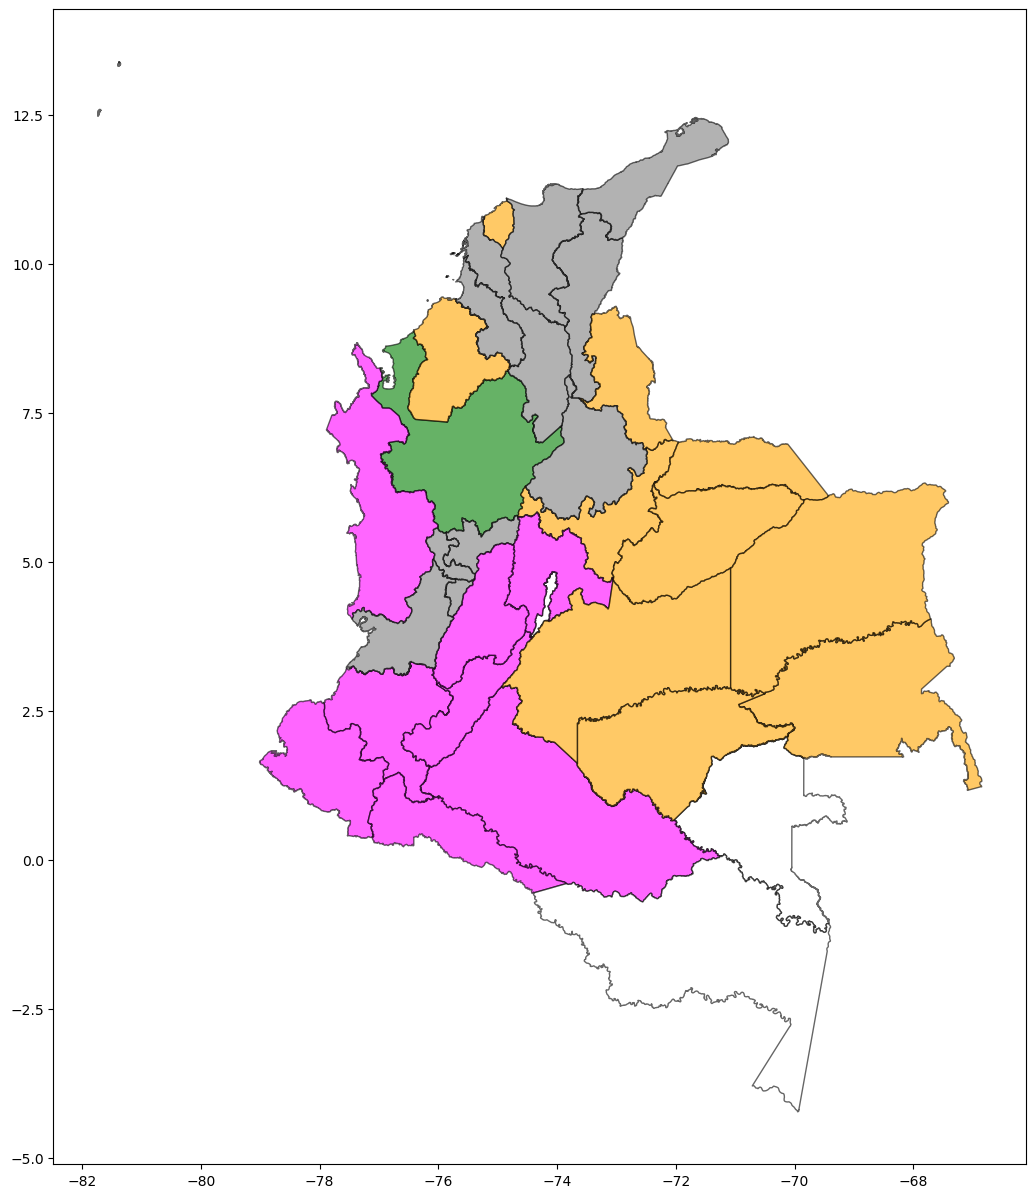

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load your shapefile
gdf = gpd.read_file('MGN_DPTO_POLITICO.shp')

# Assuming df_filtered is already defined and contains corrected names and colors
# Example of df_filtered is provided in your setup

# Merge the GeoDataFrame with df_filtered to get the colors into gdf
gdf_merged = gdf.merge(df_filtered, left_on='DPTO_CNMBR', right_on='Node Label', how='left')

# Replace NaN colors with 'white' for departments not in df_filtered
gdf_merged['Color'] = gdf_merged['Color'].fillna('white')

# Plotting the map with assigned colors and black borders for departments
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf_merged.plot(ax=ax, color=gdf_merged['Color'], edgecolor='black', alpha= 0.6)

plt.show()
